# Вариант №10

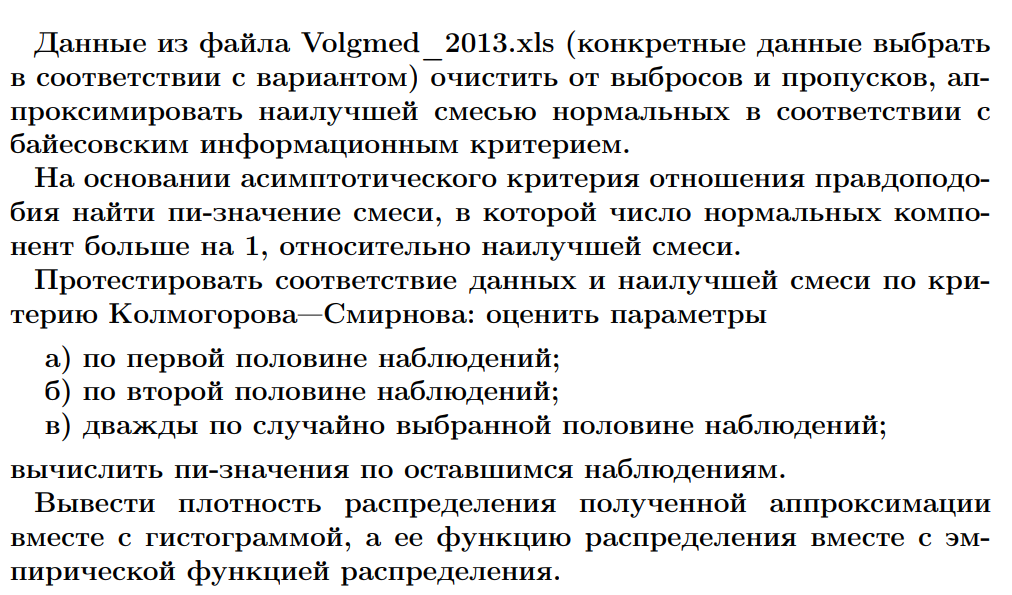

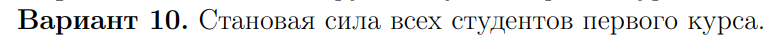

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import statsmodels
from math import sqrt, log, exp, pi
from random import uniform

In [59]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Анализ данных на Python/Volgmed_2013.xlsx', header=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12375 entries, 0 to 12374
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   № п/п                                    193 non-null    float64       
 1   Пол                                      3190 non-null   object        
 2   Год рождения                             3095 non-null   float64       
 3   Факультет                                3510 non-null   object        
 4   Курс                                     3318 non-null   float64       
 5   Группа                                   3310 non-null   float64       
 6   Год поступления                          3400 non-null   object        
 7   Дата обследования                        12009 non-null  datetime64[ns]
 8   Рост, см                                 2543 non-null   object        
 9   Вес, кг                                

In [60]:
# отбираем нужные данные, удаляем пропуски, преобразуем в тип float
data = data[['Курс', 'Становая сила, кг']]
data_course = data[data['Курс'] == 1]
data_course = data_course.dropna(axis=0, how='any')
data_course = data_course[data_course['Становая сила, кг'] != 'осв.']
data_course['Становая сила, кг'] = data_course['Становая сила, кг'].astype('float')
data_course.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 4095
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Курс               1018 non-null   float64
 1   Становая сила, кг  1018 non-null   float64
dtypes: float64(2)
memory usage: 23.9 KB


In [61]:
# избавляемся от выбросов
array=data_course.to_numpy()
q_025 = np.quantile(array[:, 1], 0.25)
q_075 = np.quantile(array[:, 1], 0.75)
iqd = q_075 - q_025
upper_limit = q_075 + 1.5 * iqd
lower_limit = q_025 - 1.5 * iqd

print('Верхняя граница =', upper_limit)
print('Нижняя граница =', lower_limit)

data_course = data_course[(data_course['Становая сила, кг'] < upper_limit) & (data_course['Становая сила, кг'] > lower_limit)]

data_sorted = data_course.sort_values(by='Становая сила, кг')
data_sorted

Верхняя граница = 137.5
Нижняя граница = -2.5


,Курс,"Становая сила, кг"
164,1.0,20.0
3356,1.0,20.0
3881,1.0,20.0
3863,1.0,25.0
3556,1.0,25.0
...,...,...
470,1.0,135.0
875,1.0,135.0
503,1.0,135.0
2763,1.0,135.0


In [62]:
# функция для аппроксимаиця смесями нормальных распределений
def gaussian_mixture(data, number):
  x = np.linspace(min(data), max(data), 2000)

  gmm = GaussianMixture(n_components=number, tol=0.000001)
  gmm.fit(np.expand_dims(data, 1))
  Gaussian_nr = 1

  for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1

  sns.histplot(data, bins=20, kde=False, stat="density")
  gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x])
  plt.plot(x, gmm_sum, label='gaussian mixture');
  plt.legend()
  plt.show()

  # print('Число компонент =', number)
  l = len(data) * gmm.score(np.expand_dims(data, 1))
  print('Логарифм функции правдоподобия =', l)

  # BIC вычисляется как k*ln(n) − 2l*
  # k - количество параметров, n - число наблюдений, l* — оптимальное значение логарифмической функции правдоподобия l
  # l = sum(ln(f(yi)))
  # для смеси q нормальных распределений k = 3q − 1
  # чем меньше BIC, тем лучше модель

  BIC = (3*number-1)*np.log(len(data)) - 2*len(data)*gmm.score(np.expand_dims(data, 1))
  print('BIC=', BIC)

  return BIC, l

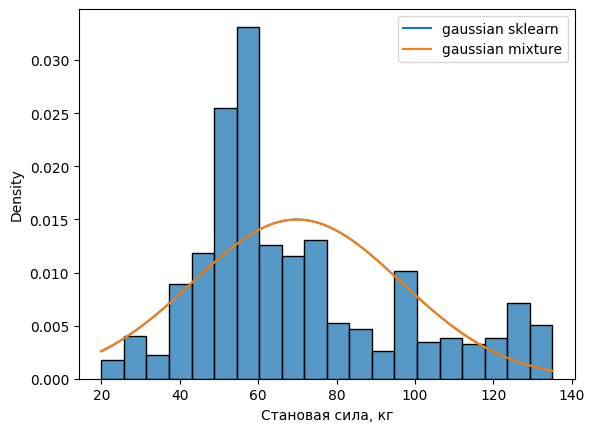

Логарифм функции правдоподобия = -4686.256523292264
BIC= 9386.322548124452


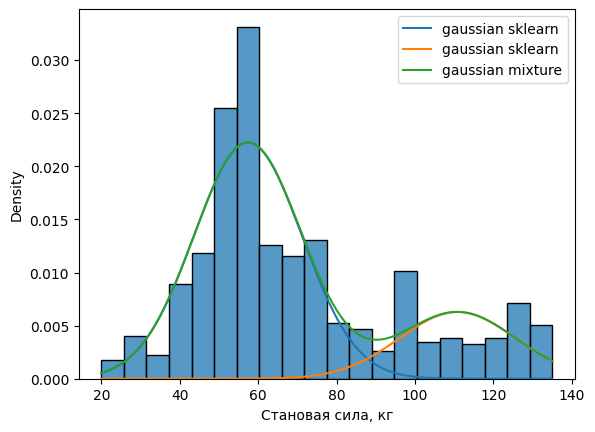

Логарифм функции правдоподобия = -4519.477070530211
BIC= 9073.477894910231


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


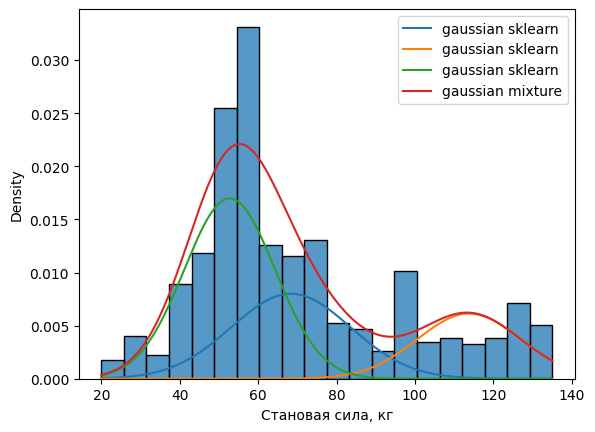

Логарифм функции правдоподобия = -4516.611668478305
BIC= 9088.461343116303


(2, 9073.477894910231, -4519.477070530211)

In [63]:
data_cut = data_course['Становая сила, кг']

best_n = 0
best_BIC = 100000000
best_l = 0
BIC_ar = []
l_ar = []
# поиск наилучшей смесью нормальных в соответствии с байесовским информационным критерием
for n in range(1, 1000):
  BIC, l = gaussian_mixture(data_cut, n)
  BIC_ar.append(BIC)
  l_ar.append(l)
  if BIC < best_BIC:
    best_BIC = BIC
    best_l = l
    best_n = n
  elif BIC > best_BIC:
    break

best_n, best_BIC, best_l
# наилучшая смесь - смесь из двух нормальных

In [64]:
# Асимптотический тест отношения правдоподобия
# λ_LR = 2(l2 − l1)

K1, K2, K3 = 2, 5, 8
print(stats.chi2.sf(2*(l_ar[1] - l_ar[0]), K2-K1))
print(stats.chi2.sf(2*(BIC_ar[1] - BIC_ar[0]), K2-K1))

5.412856323241901e-72
1.0


In [65]:
# асимптотическое пи-значение теста Колмогорова
def ks1_asympt(cdf_data):
    n = len(cdf_data)
    cdf_data.sort()
    D_n = 0
    for i in range(n):
        if max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n)) > D_n:
            D_n = max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n))
    return stats.kstwobign.sf(n ** 0.5 * D_n)

# тест Колмогорова—Смирнова
def testKolmogorovaSmirnova(data1, data2):
    gmm = GaussianMixture(n_components=2, tol=0.000001)
    gmm.fit(np.expand_dims(data1, 1))
    cdf_data = np.zeros(len(data2))
    for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        cdf_data += stats.norm(mu, sd).cdf(data2) * p

    print('p-value =', ks1_asympt(cdf_data))
    data2.sort()
    cdf_data.sort()
    ax1 = sns.ecdfplot(data1)
    ax2 = sns.ecdfplot(data2)
    ax1.axes.set_yticks(np.arange(start=0, stop=1.1, step=0.1))
    ax1.grid()
    plt.plot(data2, cdf_data)
    plt.show()

# делим данные на две части
data = data_cut.values
data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]

p-value = 3.274419075369681e-12


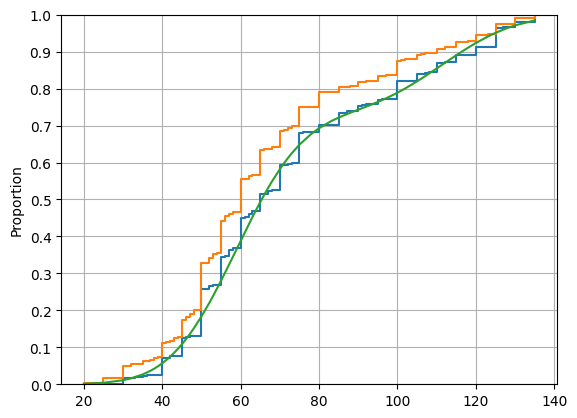

In [66]:
# по первой половине наблюдений
testKolmogorovaSmirnova(data1, data2)

p-value = 1.3886488174588305e-10


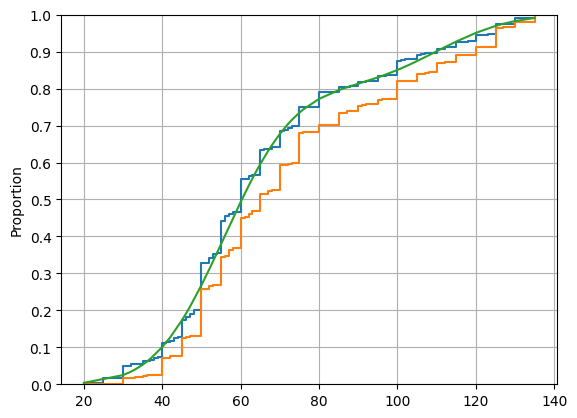

In [67]:
# по второй половине наблюдений
testKolmogorovaSmirnova(data2, data1)

p-value = 6.674100950441904e-07


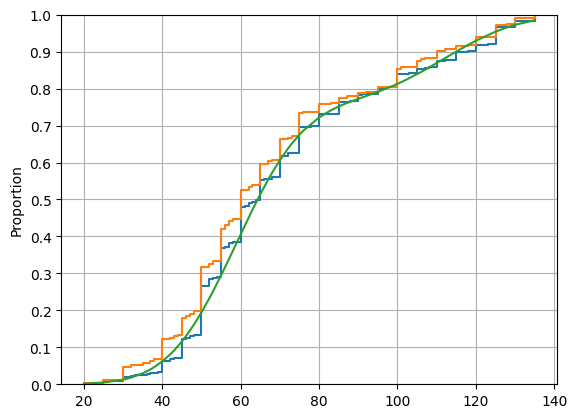

p-value = 0.001966661673640594


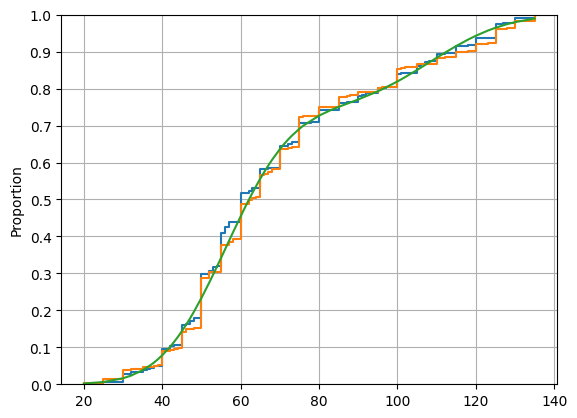

In [69]:
# дважды по случайно выбранной половине наблюдений
np.random.shuffle(data)
data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]
testKolmogorovaSmirnova(data1, data2)
np.random.shuffle(data)
data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]
testKolmogorovaSmirnova(data1, data2)